# Определяем гиперпараметры

In [1]:
BATCH_SIZE = 48
GAUSSIAN_NOISE = 0.1

# downsampling для препроцессинга
IMG_SCALING = (3, 3)
# количество изображений в валидационной выборке
VALID_IMG_COUNT = 900

MAX_TRAIN_STEPS = 7
MAX_TRAIN_EPOCHS = 5
AUGMENT_BRIGHTNESS = False

In [2]:
from keras.applications.vgg16 import VGG16
import os
import numpy as np 
import pandas as pd
from skimage.io import imread, imshow  # читаем иозбражение
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap  ### получить цветовую карту
from skimage.segmentation import mark_boundaries  ### выделение границ
#from skimage.util import montage2d as montage  
from skimage.util.montage import montage2d as montage ## перевод любого размера массива в квадратную матрицу, 
###в нашем случае для того чтобы задать соотношение сторон фотки
from skimage.morphology import binary_opening, disk, label  # бинаризация изображения, 

### для предпоказа картинок
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1) # двигаем 1 измерение 
###на последнее место меняя местами соседов

## Папки с файлами картинок
ship_dir = '../../Data'
#ship_dir = '' ##current
train_image_dir = os.path.join(ship_dir, 'train/')
test_image_dir = os.path.join(ship_dir, 'test/')



############################# Блок функций по работе с масками    #########################################################
def multi_rle_encode(img, **kwargs):
    ##кодируем связанные области в виде раздельных масок. на вхд подаем изображение и получаем RLE формат для областей
    ## с одинаковым цветом. по сути несколько раз подавая на вход кодеру маски из 0 и 1 для каждой уникальной области

    ##labels = label(img)
    labels = img
    if img.ndim > 2:
        ## берем уникальные значения label, передаем в encode матрицу  h x w где каналы схлопнуты по сумме. получается 
        ## двумерный массив из 0 и сумм по каналам
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    Кодируем маску в формат RLE. Навход подаем img 2d из 0 и не 0
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten() ### вытягиваем изображение в одномерный вектор, читая его по строкам. 
    ##Берем первую строчку, первый столбце и вытаскиваем три канала, потом второй столбец
    pixels = np.concatenate([[0], pixels, [0]]) ## добавляем два нуля побокам
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 ### вычисляем номера пикселей, где есть переход
    # от 0 к 1 - это будет граница
    runs[1::2] -= runs[::2] ## строим маску вычитаем: из номеров пикселей через один их соседей. 
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    Восстанавливаем маску размера shape по RLE
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

# ТАк как у нас в файле с масками разные корабли на одном изображении кодируются отдельной строкой,
# То нужна функция объеденяющая несколько масок в одну со всеми кораблями
def masks_as_image(in_mask_list):
    # Объеденим массив масок отдельных кораблей в один. т.е. если у нас для изображения несколько строк с масками
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask) ## битовый  or a = a | b
    return all_masks

def masks_as_color(in_mask_list):
    # создаем массив цветных масок для каждого корабля. Т.е. если несколько масок для картинки, то каждый корабль своим цветом
    # Первая маска будет под цифрой 1, вторая под цифрой 2 и т.д.
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2)
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

Using TensorFlow backend.


In [3]:
import keras.backend as K

## определяем целевую функцию

def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

## Читаем файл с масками, смотрим статистику пустых

In [4]:
masks = pd.read_csv('train_ship_segmentations.csv',encoding= 'utf-8', delimiter=',')
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

56030 masks in 29070 images
75000 empty images in 104070 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


## Проводим анализ данных

In [5]:
# Посмотрим сколько кораблей у нас есть на каждом изображении, размер файлов с изображениямии
# И отсечем "битые"

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
77553,beb4337d4.jpg,0,0.0,[0.0],189.383789
63201,9b2d517a0.jpg,2,1.0,[1.0],126.421875
49424,7966938ce.jpg,0,0.0,[0.0],130.829102
55460,88450d7ef.jpg,2,1.0,[1.0],103.685547
1965,04b2eb65d.jpg,0,0.0,[0.0],106.105469
21414,349a8f3d8.jpg,0,0.0,[0.0],95.937500
91421,e10bbc5c8.jpg,0,0.0,[0.0],174.260742


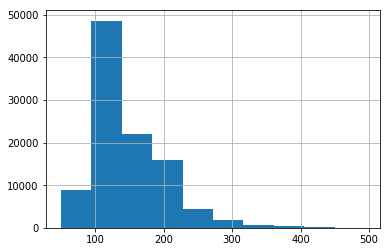

In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
#unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] < 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

### Смотрим как часто встречаются снимки без кораблей

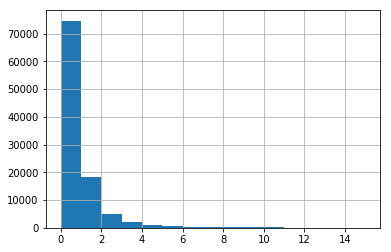

In [7]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

## Undersample "пустых" изображений
Делаем undersample пустых изображений, чтобы получить сбалансированные группы. Так как у нас намного больше изображений без кораблей. Оставляем всего порядка 11000 изображений. Что составляет примерно 10% от всего объема трейна

11256 masks


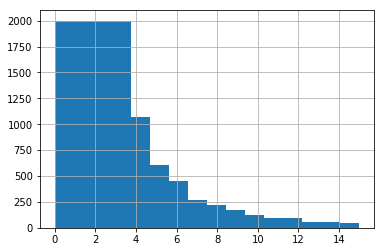

In [8]:
## Группируем по количеству кораблей, если в группе больше 2000 то берем рандомные 2000, если меньше то просто берем все
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [9]:
#### Получили 15 групп по количеству изображений в каждой

## Делим на трайн и валид со стратификацией по количеству кораблей на изображениях

In [10]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.3, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

24353 training masks
10440 validation masks


In [11]:
train_df.head()

,ImageId,EncodedPixels,ships,has_ship,has_ship_vec,file_size_kb
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,1.0,[1.0],147.625977
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9,1.0,[1.0],242.910156
2,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9,1.0,[1.0],242.910156
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9,1.0,[1.0],242.910156
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,9,1.0,[1.0],242.910156


# Переводим все маски в изображения
Создаем под это дело генератор

In [12]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId')) ## получаем список кортежей, где первый элемент - снимок, а второй описание
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches) ## Перемешиваем набор
        for c_img_id, c_masks in all_batches: ##Берем наименование картинки и описание(в нем содержатся и маски)
            rgb_path = os.path.join(train_image_dir, c_img_id) ##Получаем путь картинки в папке
            c_img = imread(rgb_path) ##Читаем картинку
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)## Передаем в функцию массив масок ,
            # получаем массив 2d из 0 и 1. Добавляем в него 3 измерение. В итоге получаем rgb маску
            if IMG_SCALING is not None: # Ужимаем изображение в n раз
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size: # Когда количество картинок достигает размера бача
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0) ## Возращаем генератор картинок 
               ## out_rgb, out_mask=[], []

In [13]:
train_gen = make_image_gen(train_df) ## создаем генератор
train_x, train_y = next(train_gen) ## Вызываем его первый раз
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


In [14]:
###Получаем 4d массив, где первое измерение создержит картинку, а остальные три ее координаты

### Нарисуем, что получилось при создании бача

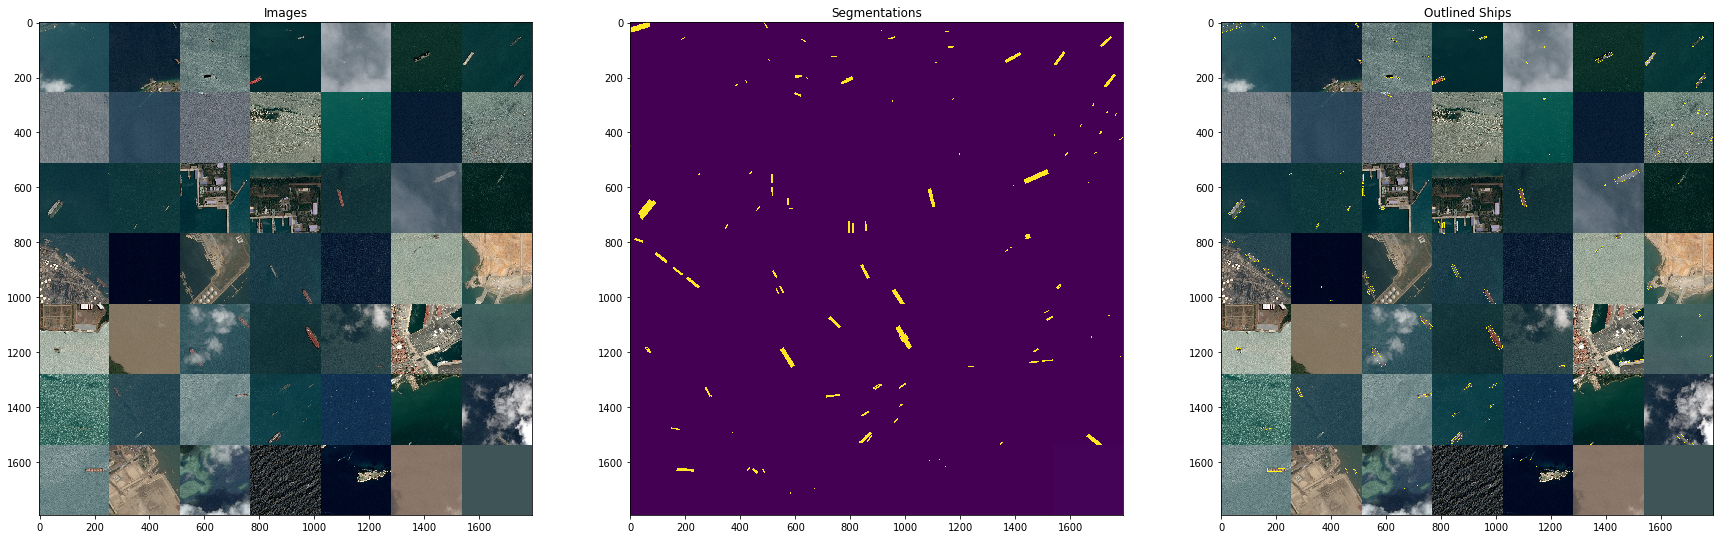

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Генерим валидационный набор

In [16]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
CPU times: user 12.5 s, sys: 1.42 s, total: 14 s
Wall time: 15 s


# Аугументация данных

In [17]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01, 
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, ## Переворачиваем по горизонтали
                  vertical_flip = True, ## Поворачиваем по вертикали
                  fill_mode = 'reflect', ###  как заполнять пустые зоны
                   data_format = 'channels_last')
if AUGMENT_BRIGHTNESS: ### делаем ли аугментацию яркости?
    dg_args['brightness_range'] = [0.5, 1.5] ### добавляем диапазон изменения яркости в словарь парметров
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range') ###  для масок удаляем яркость, так как там только один цвет
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        #сохраняем синхронизацию seed, в противном случае увеличение изображений отличается от масок
        g_x = image_gen.flow(in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x), next(g_y)

## Посмотрим как работает аугументация. Вызываем генератор, смотрим на размеры данных.
### смотрим 9 картинок и масок

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


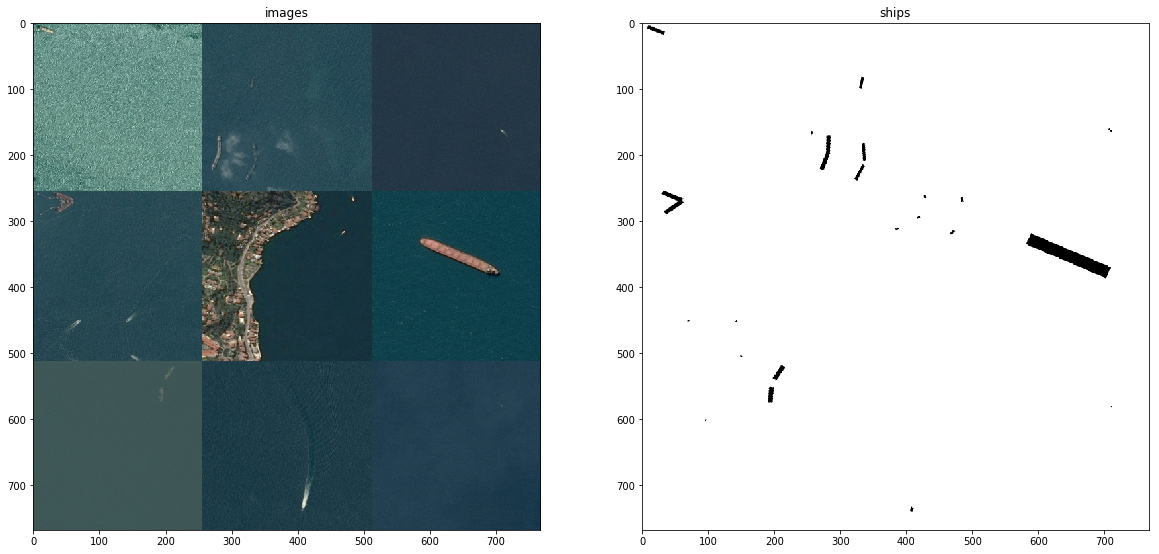

In [18]:
##train_gen = make_image_gen(train_df)
cur_gen = create_aug_gen(make_image_gen(train_df))
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')
fig.savefig('overview2.png')

In [19]:
## Функции для апсэмлинга
from keras import models, layers
def upsample_conv(filters, kernel_size, strides, padding): ## делаем паддинг и проходимся фильтром с весами
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(size = strides) ## Обычная линейная интерполяция k ближайших соседей

#Колчество шагов в эпохе
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)



# Описываем класс с нашими моделями

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

class Model ():
    def __init__(self, model_type,  data_gen,   \
                 max_train_epochs = MAX_TRAIN_EPOCHS , \
                 loss = IoU, upsample_func = upsample_simple,\
                 step_count=step_count, valid_x=valid_x, valid_y = valid_y):
        
        self.model_type = model_type
        self.name = model_type  ##Имя файла с весами
        self.data_gen = data_gen
        self.upsample_func = upsample_func ## upsample метод
        self.seg_model = None   ## переменная мощдели
        self.loss = loss ## Определяем функцию потерь
        self.max_train_epochs= max_train_epochs
        self.step_count = step_count
        self.valid_x = valid_x
        self.valid_y = valid_y
        
        if self.model_type =='seg_w_tun':
            # Добавляем в "ванильную модель" тюнинг: батч нормализацию, зашумление convolution transponse вместо upsapling
            # ELu втесто Relu
            upsample = self.upsample_func

            i1 = layers.Input(t_x.shape[1:], name = 'RGB_Input')
            i2 = layers.GaussianNoise(GAUSSIAN_NOISE)(i1)
            i3 = layers.BatchNormalization()(i2)

            c1 = layers.Conv2D(8, (3, 3), activation='elu', padding='same') (i3)
            с1 = layers.Dropout(0.2)(c1)
            c1 = layers.Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
            p1 = layers.MaxPooling2D((2, 2)) (c1)

            c2 = layers.Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
            с2 = layers.Dropout(0.2)(c2)
            c2 = layers.Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
            p2 = layers.MaxPooling2D((2, 2)) (c2)

            c3 = layers.Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
            с3 = layers.Dropout(0.2)(c3)
            c3 = layers.Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
            p3 = layers.MaxPooling2D((2, 2)) (c3)

            c4 = layers.Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
            с4 = layers.Dropout(0.2)(c4)
            c4 = layers.Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
            p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


            c5 = layers.Conv2D(128, (3, 3), activation='elu', padding='same') (p4)
            с5 = layers.Dropout(0.2)(c5)
            c5 = layers.Conv2D(128, (3, 3), activation='elu', padding='same') (c5)

            u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
            u6 = layers.concatenate([u6, c4])
            c6 = layers.Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
            с6 = layers.Dropout(0.2)(c6)
            c6 = layers.Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

            u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
            u7 = layers.concatenate([u7, c3])
            c7 = layers.Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
            с7 = layers.Dropout(0.2)(c7)
            c7 = layers.Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

            u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
            u8 = layers.concatenate([u8, c2])
            c8 = layers.Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
            с8 = layers.Dropout(0.2)(c8)
            c8 = layers.Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

            u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
            u9 = layers.concatenate([u9, c1], axis=3)
            c9 = layers.Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
            с9 = layers.Dropout(0.2)(c9)
            c9 = layers.Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

            o = layers.Conv2D(1, (1, 1), activation='softmax') (c9)

            self.seg_model = models.Model(inputs=[i1], outputs=[o])
            self.seg_model.summary()
            
            
#####################################################################################
        if self.model_type =='seg_vanilla':
            # Ванильная модель без тюнинга
    
            upsample = self.upsample_func

            i1 = layers.Input(t_x.shape[1:], name = 'RGB_Input')



            c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (i1)
            c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
            p1 = layers.MaxPooling2D((2, 2)) (c1)

            c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
            c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
            p2 = layers.MaxPooling2D((2, 2)) (c2)

            c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
            c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
            p3 = layers.MaxPooling2D((2, 2)) (c3)

            c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
            c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
            p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


            c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
            c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

            u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
            u6 = layers.concatenate([u6, c4])
            c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
            c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

            u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
            u7 = layers.concatenate([u7, c3])
            c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
            c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

            u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
            u8 = layers.concatenate([u8, c2])
            c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
            c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

            u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
            u9 = layers.concatenate([u9, c1], axis=3)
            c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
            c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

            o = layers.Conv2D(1, (1, 1), activation='softmax') (c9)

            self.seg_model = models.Model(inputs=[i1], outputs=[o])
            self.seg_model.summary()
        
#####################################################################################
        if self.model_type =='vgg_unet':
            # Предобученный декодер

            i  = VGG16(weights='imagenet', include_top= False, input_shape= t_x.shape[1:])
            # фиксируем все веса предобученной сети

            for layer in i.layers:
                layer.trainable = False

            o = i.layers[-5].output



            o = layers.ZeroPadding2D( (1,1)  )(o)
            o = layers.Conv2D(512, (3, 3), padding='valid')(o)
            o = layers.BatchNormalization()(o)

            o = layers.UpSampling2D( (2,2))(o)
            o = layers.concatenate([ o ,i.layers[13].output],axis=3)  
            o = layers.ZeroPadding2D( (1,1))(o)
            o = layers.Conv2D( 256, (3, 3), padding='valid')(o)
            o = layers.BatchNormalization()(o)

            o = layers.UpSampling2D( (2,2))(o)
            o = layers.concatenate([o,i.layers[6].output],axis=3 ) 
            o = layers.ZeroPadding2D((1,1))(o)
            o = layers.Conv2D( 128 , (3, 3), padding='valid' ) (o)
            o = layers.BatchNormalization()(o)

            o = layers.UpSampling2D( (2,2))(o)
            o = layers.concatenate([o,i.layers[3].output],axis=3 ) 
            o = layers.ZeroPadding2D((1,1)   )(o)
            o = layers.Conv2D( 64 , (3, 3), padding='valid' )(o)
            o = layers.BatchNormalization()(o)

            o = layers.UpSampling2D( (2,2))(o)
            o = layers.ZeroPadding2D((1,1) )(o)
            o = layers.Conv2D( 64 , (3, 3), padding='valid' )(o)
            o = layers.BatchNormalization()(o)

            o = layers.Conv2D(1, (1, 1), activation='softmax') (o)



            self.seg_model = models.Model(inputs=[i.input], outputs=[o])
            self.seg_model.summary()

        
    def call_back(self):
        weight_path="{}_weights.best.hdf5".format(self.model_type)
        ### Опеределяем callback функции, которые вызвываеются после каждой эпохи 
        ###Сохраняем модель после каждой эпохи, сохраняем только лучшие веса
        checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

        ## меняем LR, если в течении эпохи не было существенного изменения val_los, если изменение будет меньше min_delta 
        reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                           patience=1, verbose=1, mode='min',
                                           min_delta=0.0001, cooldown=0, min_lr=1e-8)

        ## Прекращаем обучение, когда лос престает меняться ждем 10 эпох
        early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                              patience=10) 

        callbacks_list = [checkpoint, early, reduceLROnPlat]
        return callbacks_list
        
        
        ############# Компилируем #####################
    def Compile (self):
        self.seg_model.compile(optimizer=Adam(5e-4, decay=1e-5), loss=self.loss, metrics=['binary_accuracy'])
    ####################### Обучаем###############
    def Fit(self):
        loss = self.seg_model.fit_generator(data_gen,
                             steps_per_epoch=self.step_count,
                             epochs=self.max_train_epochs,
                             validation_data=(self.valid_x, self.valid_y),
                             callbacks=self.call_back(),
                             workers=1 
                                       )
        return loss
            
        
        

## u-net ванильная

In [26]:
# без аугментации
data_gen = make_image_gen(train_df)

## Создаем модель
seg_vanilla = Model(model_type = 'seg_vanilla',  data_gen = data_gen)

## Компилируем и обучаем
seg_vanilla.Compile()
loss_history_vanilla = seg_vanilla.Fit()

## Загружаем лучшие веса и сохраняем
weight_path="{}_weights.best.hdf5".format('seg_vanilla')
seg_vanilla.seg_model.load_weights(weight_path) ## загружаем лучшие веса
seg_vanilla.seg_model.save('seg_vanilla.h5') ##сохраняем модель


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 8)  224         RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 8)  584         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 


Epoch 00004: val_loss did not improve from -0.00519

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: -0.0076 - binary_accuracy: 0.0076 - val_loss: -0.0052 - val_binary_accuracy: 0.0052

Epoch 00005: val_loss did not improve from -0.00519

Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.000000889296644e-07.
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: -0.0075 - binary_accuracy: 0.0075 - val_loss: -0.0052 - val_binary_accuracy: 0.0052

Epoch 00006: val_loss did not improve from -0.00519

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.6000001323845936e-07.
Epoch 7/10
7/7 [==============================] - 11s 2s/step - loss: -0.0077 - binary_accuracy: 0.0077 - val_loss: -0.0052 - val_binary_accuracy: 0.0052

Epoch 00007: val_loss did not improve from -0.00519

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-08.
E

# u-net тюнингованная

In [69]:
# Будем использовать аугментацию
data_gen = create_aug_gen(make_image_gen(train_df))

## Создаем модель
seg_w_tun = Model(model_type = 'seg_w_tun',  data_gen = data_gen, upsample_func = upsample_conv )

## Компилируем и обучаем
seg_w_tun.Compile()
loss_history_tun = seg_w_tun.Fit()

## Загружаем лучшие веса и сохраняем
weight_path="{}_weights.best.hdf5".format('seg_w_tun')
seg_w_tun.seg_model.load_weights(weight_path) ## загружаем лучшие веса
seg_w_tun.seg_model.save('seg_w_tun.h5') ##сохраняем модель


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 3)  12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 8)  224         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_40 

7/7 [==============================] - 19s 3s/step - loss: -0.0042 - binary_accuracy: 0.0033 - val_loss: -0.0052 - val_binary_accuracy: 0.0052

Epoch 00003: val_loss did not improve from -0.00519

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
Epoch 4/10
7/7 [==============================] - 21s 3s/step - loss: -0.0046 - binary_accuracy: 0.0036 - val_loss: -0.0052 - val_binary_accuracy: 0.0052

Epoch 00004: val_loss did not improve from -0.00519

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
Epoch 5/10
7/7 [==============================] - 22s 3s/step - loss: -0.0043 - binary_accuracy: 0.0033 - val_loss: -0.0052 - val_binary_accuracy: 0.0052

Epoch 00005: val_loss did not improve from -0.00519

Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.000000889296644e-07.
Epoch 6/10
7/7 [==============================] - 23s 3s/step - loss: -0.0041 - binary_accuracy: 0.0031 - val_loss: -0.0052 - val_binary_accuracy:

 # VGG + U-Net

In [21]:
# Будем использовать аугментацию
data_gen = create_aug_gen(make_image_gen(train_df))

## Создаем модель
vgg_unet = Model(model_type = 'vgg_unet',  data_gen = create_aug_gen(make_image_gen(train_df)))

## Компилируем и обучаем
vgg_unet.Compile()
loss_history_vgg = vgg_unet.Fit()

## Загружаем лучшие веса и сохраняем
weight_path="{}_weights.best.hdf5".format('vgg_unet')
vgg_unet.seg_model.load_weights(weight_path) ## загружаем лучшие веса
vgg_unet.seg_model.save('vgg_unet.h5') ##сохраняем модель

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

Epoch 1/5
7/7 [==============================] - 125s 18s/step - loss: -0.0053 - binary_accuracy: 0.0041 - val_loss: -0.0053 - val_binary_accuracy: 0.0053

Epoch 00001: val_loss improved from inf to -0.00535, saving model to vgg_unet_weights.best.hdf5
Epoch 2/5
7/7 [==============================] - 131s 19s/step - loss: -0.0051 - binary_accuracy: 0.0040 - val_loss: -0.0053 - val_binary_accuracy: 0.0053

Epoch 00002: val_loss did not improve from -0.00535

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/5
7/7 [==============================] - 145s 21s/step - loss: -0.0056 - binary_accuracy: 0.0045 - val_loss: -0.0053 - val_binary_accuracy: 0.0053

Epoch 00003: val_loss did not improve from -0.00535

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
Epoch 4/5
7/7 [==============================] - 156s 22s/step - loss: -0.0054 - binary_accuracy: 0.0043 - val_loss: -0.0053 - val_binary_accuracy: 0.0053

Epoch 00004:

## Визуализируем результаты обучения

In [23]:

def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
            [np.linspace(0.5, 1, len(loss_history.epoch)) ]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    _ = ax1.plot(epich,
                loss_history.history['loss'],
                 'b-',
                 epich,loss_history.history['val_loss'], 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

   
    
    _ = ax2.plot(epich, 
        loss_history.history['binary_accuracy'] , 'b-',
                     epich,loss_history.history['val_binary_accuracy'] ,
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')
    




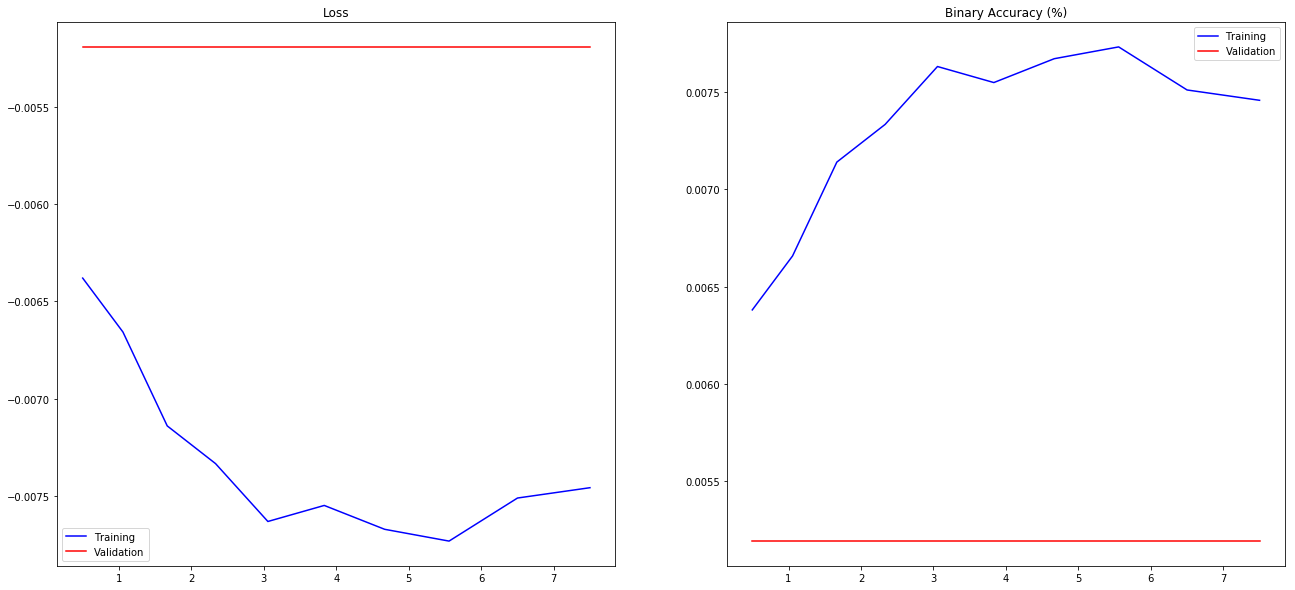

In [68]:
##Для ВАнильной модели
show_loss(loss_history_vanilla)

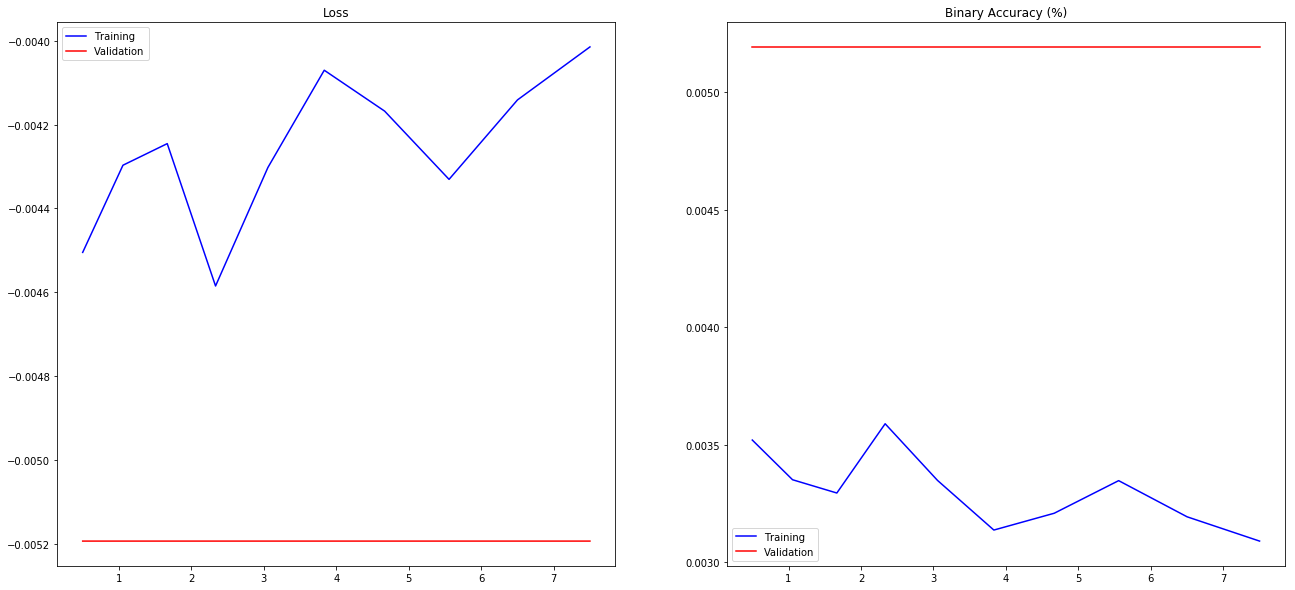

In [70]:
##Для тюнингованной модели
show_loss(loss_history_tun)

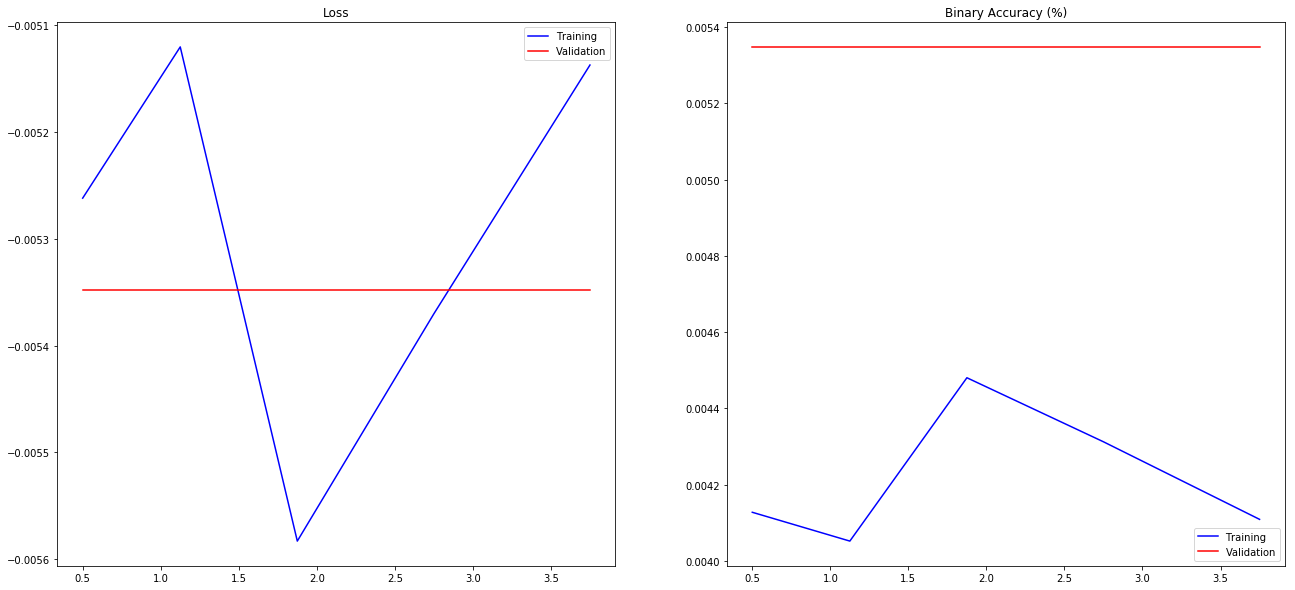

In [24]:
##Для тюнингованной модели
show_loss(loss_history_vgg)

## Делаем предсказания на валидационном наборе

In [23]:
pred_y = seg_vanilla.seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(900, 256, 256, 1) 1.0 1.0 1.0


## Посмотрим, распределение предсказаний

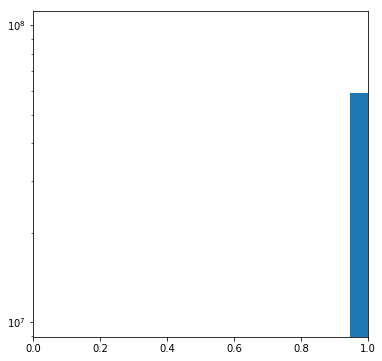

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

# Визуализируем предсказания

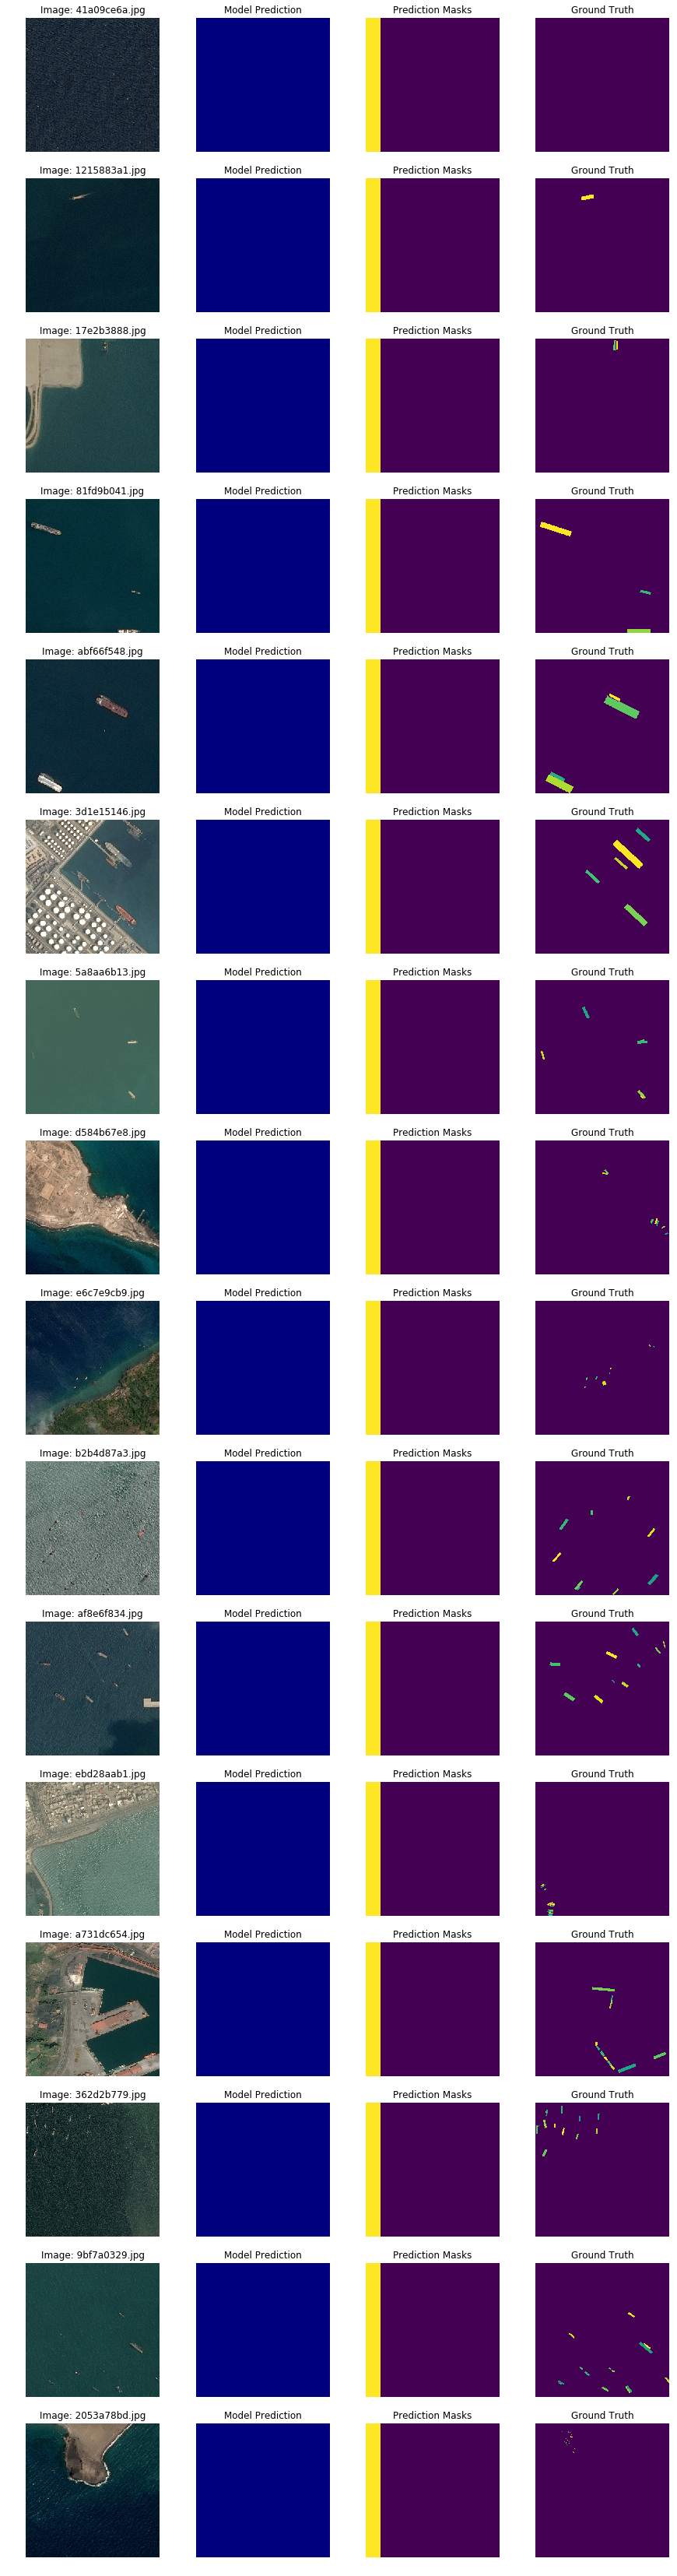

In [32]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
    c_img = np.expand_dims(c_img, 0)/255.0 ## Заглушка, в метод предикт нужно подавать тензор 4d
    cur_seg = seg_vanilla.seg_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.9, np.expand_dims(disk(2), -1)) ## , удаляем шум с изображений
    ###np.expand_dims(disk(2), -1) создаем массив 5х5 из едениц образующих повернутый 45 квардат и добавляем 3 измерение в него

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

samples = valid_df.groupby('ships').apply(lambda x: x.sample(1)) ##Группируем валидационные данные по количеству кораблей и 
## бермм по одному примеру из каждоый группы
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, 60)) # рисуем n строк по 4 стобца в кадом
[c_ax.axis('off') for c_ax in m_axs.flatten()] 



for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values): ##Берем картинку строим для нее 4 графика
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir) ## Выдаем предсказанную маску и изображение
    
    #Само изображение
    ax1.imshow(first_img)  
    ax1.set_title('Image: ' + c_img_name)
    
    # Пресказание модели
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    
    ## Предсказанные маски
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    
    #Показываем реальную маску 
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')